<a href="https://colab.research.google.com/github/raiadi96/Pytorch/blob/master/CNNonCIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

In [29]:
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url,'.')

Using downloaded and verified file: ./cifar10.tgz


In [0]:
with tarfile.open('./cifar10.tgz','r:gz') as tar:
  tar.extractall(path = './data')

In [31]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['train', 'test', 'labels.txt']
['horse', 'ship', 'truck', 'cat', 'automobile', 'bird', 'dog', 'deer', 'frog', 'airplane']


In [0]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [0]:
dataset = ImageFolder(data_dir+'/train', transform = ToTensor())

In [0]:
def plot_images(img, label):
  import matplotlib.pyplot as plt
  plt.imshow(img.permute(1,2,0))
  print(dataset.classes[label])

airplane


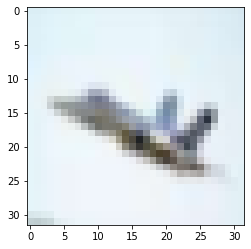

In [35]:
plot_images(*dataset[0])

automobile


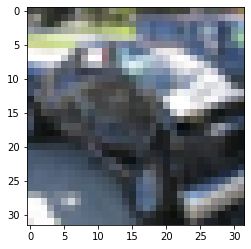

In [36]:
plot_images(*dataset[5555])

In [0]:
import numpy as np

def split_indices(n, val_pct = 0.1, seed = 99):
  n_val =  int(val_pct * n)
  np.random.seed(seed)
  idxs = np.random.permutation(n)
  return idxs[n_val:], idxs[:n_val]

In [38]:
val_pct = 0.2
rand_seed = 42
train_indices, val_indices = split_indices(len(dataset),val_pct, rand_seed)
print(len(train_indices), len(val_indices))

40000 10000


In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

batch_size = 100


In [0]:
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, batch_size, sampler = train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset, batch_size, sampler = val_sampler)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
model = nn.Sequential(
    nn.Conv2d(3,16, kernel_size = 1, stride = 1, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 8 x 8

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 4 x 4
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 2 x 2

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 1 x 1,
    
    nn.Flatten(), # output: bs x 16
    nn.Linear(16, 10) # output: bs x 10 
)

In [0]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [45]:
device = get_default_device()
device


device(type='cpu')

In [46]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(train_dl, device)
to_device(model, device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten()
  (16): Linear(in_features=16, out_features=10, bias=True)
)